In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from scipy import signal, interpolate

## Question 1

### a.)

To create the noise model, we simply need to window the data and find the power spectrum. I chose to use the welch method with a tukey window, since it applies the window and also outputs the power spectrum conveniently.
For smoothening the power spectrum, I chose to convolve our it with a gaussian function since it has a extended flat period. 

In [40]:
directory = 'LOSC_Event_tutorial/'

def read_template(filename):
    dataFile=h5py.File(directory+filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    
    return th,tl

def read_file(filename):
    dataFile=h5py.File(directory+filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    dataFile.close()
    
    return strain,dt,utc

In [41]:
with open(directory+'BBH_events_v3.json') as file:
    json_dat = json.load(file)
list_events = list(json_dat.keys())
H_event, L_event, H_template, L_template = [],[],[],[]

for i in range(len(list_events)):
    event = list_events[i]
    H = json_dat[event]['fn_H1']
    L = json_dat[event]['fn_L1']
    temp = json_dat[event]['fn_template']
    H_event.append(read_file(H))
    L_event.append(read_file(L))
    H_temp, L_temp = read_template(temp)
    H_template.append(H_temp)
    L_template.append(L_temp)
file.close()

In [42]:
def Smooth(x):
    fft = np.fft.fft(x)
    n = np.arange(len(x))
    fun = np.exp(-0.5 * (n)**2)
    funfft = np.fft.fft(fun)
    return np.abs(np.fft.ifft(fft * funfft))

In [46]:
def Noise():
    noise = []
    for i in range(len(L_event)):
        H_strain, H_dt = np.array(H_event, dtype = object).T[:2,i]
        L_strain, L_dt = np.array(L_event, dtype = object).T[:2,i]
        H_freq, H_pxx = signal.welch(H_strain, 1/H_dt, nperseg = 1/H_dt, window = 'tukey')
        L_freq, L_pxx = signal.welch(L_strain, 1/L_dt, nperseg = 1/L_dt, window = 'tukey')
        H_noise = Smooth(H_pxx)
        L_noise = Smooth(L_pxx)
        plt.loglog(H_noise, label = 'Hanford')
        plt.loglog(L_noise, label = 'Livingston')
        plt.legend()
        plt.show()
        noise.append({"H_noise": H_noise, "L_noise": L_noise,
                      "H_freq": H_freq, "L_freq": L_freq, 
                      "H_strain": H_strain, "L_strain": L_strain,
                      "H_dt": H_dt, "L_dt": L_dt,
                      "H_template": H_template[i], "L_template": L_template[i]})
       
    return noise

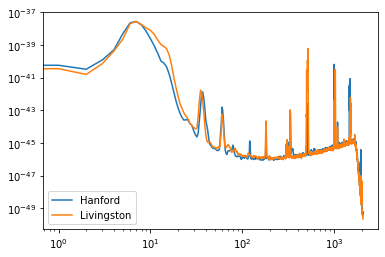

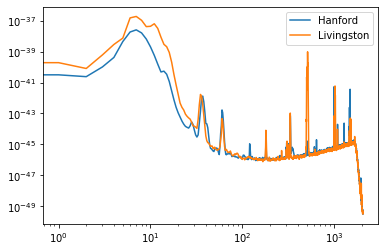

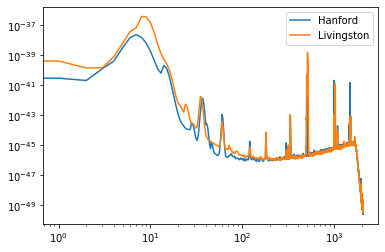

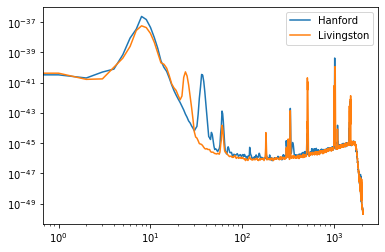

In [47]:
data = Noise()

## b.)

In [45]:
def white(event):
    Hnoise_spectrum_intp = interpolate.interp1d(event['H_freq'],event['H_noise'],kind='linear')
    Hspectr1 = np.fft.fft(event['H_strain'] * signal.get_window(window = 'tukey', Nx = len(event['H_strain'])))
    Hspectr2 = np.fft.fft(event['H_template'] * signal.get_window(window = 'tukey', Nx = len(event['H_template'])))
    
    Hfreq = np.fft.fftfreq(len(event['H_template']), event['H_dt'])
    
    Hspectr1 = Hspectr1/np.sqrt(Hnoise_spectrum_intp(np.abs(Hfreq)))
    Hspectr2 = Hspectr2/np.sqrt(Hnoise_spectrum_intp(np.abs(Hfreq)))
    Hwhite1 = np.fft.ifft(Hspectr1)
    Hwhite2 = np.fft.ifft(Hspectr2)
    
    Lnoise_spectrum_intp = interpolate.interp1d(event['L_freq'],event['L_noise'],kind='linear')
    Lspectr1 = np.fft.fft(event['L_strain'] * signal.get_window(window = 'tukey', Nx = len(event['L_strain'])))
    Lspectr2 = np.fft.fft(event['L_template'] * signal.get_window(window = 'tukey', Nx = len(event['L_template'])))
    
    Lfreq = np.fft.fftfreq(len(event['L_template']), event['L_dt'])
    
    Lspectr1 = Lspectr1/np.sqrt(Lnoise_spectrum_intp(np.abs(Lfreq)))
    Lspectr2 = Lspectr2/np.sqrt(Lnoise_spectrum_intp(np.abs(Lfreq)))
    Lwhite1 = np.fft.ifft(Lspectr1)
    Lwhite2 = np.fft.ifft(Lspectr2)
    
    return Hwhite1, Hwhite2 ,Lwhite1, Lwhite2, Hfreq, Lfreq
                                          
def match_filter(event):
    Hfs = 1/event['H_dt']
    Lfs = 1/event['L_dt']
    
    Hsignal_white, H_white_spect, Lsignal_white, L_white_spect, Hfreq, Lfreq = white(event)
    
    Hsignal_white = np.fft.fft(Hsignal_white) / Hfs
    H_white_spect = np.fft.fft(H_white_spect) / Hfs
    Lsignal_white = np.fft.fft(Lsignal_white) / Lfs
    L_white_spect = np.fft.fft(L_white_spect) / Lfs
    
    Hmf = Hsignal_white * H_white_spect.conjugate()
    Hmf = np.fft.ifft(Hmf)
    Lmf = Lsignal_white * L_white_spect.conjugate()
    Lmf = np.fft.ifft(Lmf)
    
    Ht = np.arange(len(event['H_strain']) * event['H_dt'], step = event['H_dt'])
    Lt = np.arange(len(event['L_strain']) * event['L_dt'], step = event['L_dt'])

    
    return Ht, Hmf, Lt, Lmf

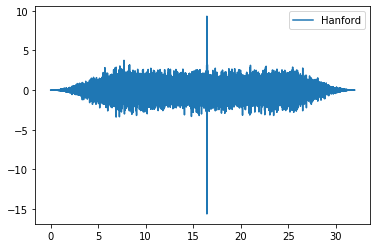

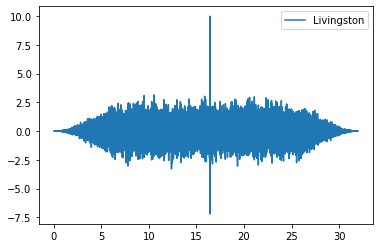

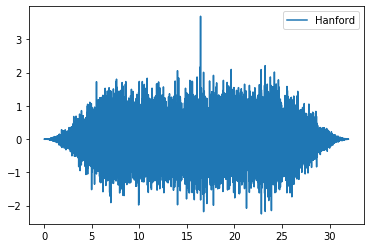

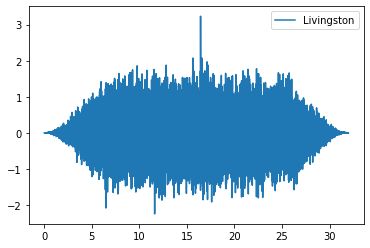

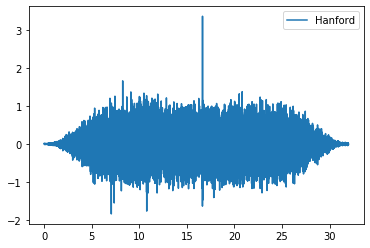

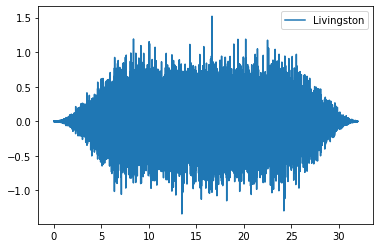

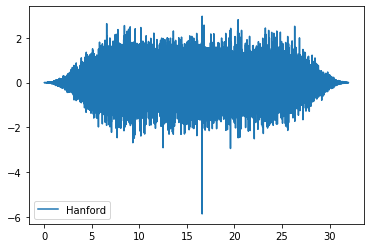

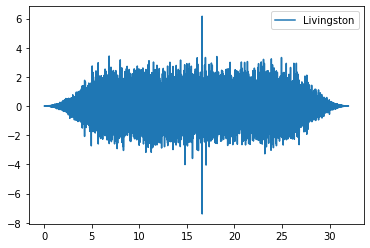

In [22]:
for i in range(len(list_events)):
    Ht, Hmf, Lt, Lmf = match_filter(data[i])
    Htshift = np.fft.fftshift(Ht)
    Ltshift = np.fft.fftshift(Lt)

    plt.plot(Htshift, np.real(Hmf), label = 'Hanford')
    plt.legend()
    plt.show()
    plt.plot(Ltshift, np.real(Lmf), label = 'Livingston')
    plt.legend()
    plt.show()

## c.)

In [70]:
est_SNR = np.zeros((len(list_events),2))
for i in range(len(list_events)):
    Ht, Hmf, Lt, Lmf = match_filter(data[i])
    Hnoise = np.std(Hmf[5000:35000])
    HSNR = np.max(np.abs(Hmf))/Hnoise
    Lnoise = np.std(Lmf[5000:35000])
    LSNR = np.max(np.abs(Lmf))/Lnoise
    est_SNR[i,0] = HSNR
    est_SNR[i,1] = LSNR
    comb = np.sqrt(LSNR**2 + HSNR**2)
    print('Estimated Hanford SNR = ', HSNR,'Estimated Livingston SNR =', LSNR, 'Combined SNR =', comb)

Estimated Hanford SNR =  17.601027847292013 Estimated Livingston SNR = 12.197033291640132 Combined SNR = 21.41410288568089
Estimated Hanford SNR =  6.532083837097693 Estimated Livingston SNR = 5.955523998133934 Combined SNR = 8.83947879386687
Estimated Hanford SNR =  8.76587212784275 Estimated Livingston SNR = 4.940284273524566 Combined SNR = 10.062152993516076
Estimated Hanford SNR =  8.388200547387106 Estimated Livingston SNR = 7.851459098303718 Combined SNR = 11.489443780946123


## d.)

In [33]:
def SNR(event):
    Hfs = 1/event['H_dt']
    Lfs = 1/event['L_dt']
    Hsignal_white, H_white_spect, Lsignal_white, L_white_spect, Hfreq, Lfreq = white(event)
    
    Hsignal_white = np.fft.fft(Hsignal_white) / Hfs
    H_white_spect = np.fft.fft(H_white_spect) / Hfs
    Lsignal_white = np.fft.fft(Lsignal_white) / Lfs
    L_white_spect = np.fft.fft(L_white_spect) / Lfs
    
    Htemp_fft = np.fft.fft(event['H_template']) / Hfs
    Ltemp_fft = np.fft.fft(event['L_template']) / Lfs
    
    Hdf = np.abs(Hfreq[1] - Hfreq[0])
    Ldf = np.abs(Lfreq[1] - Lfreq[0])

    Hnoise = np.interp(np.abs(Hfreq), Hfreq, Htemp_fft)
    Lnoise = np.interp(np.abs(Lfreq), Lfreq, Ltemp_fft)

    
    HSNR = Hsignal_white * H_white_spect.conjugate() / np.sqrt(Hnoise)
    LSNR = Lsignal_white * L_white_spect.conjugate() / np.sqrt(Lnoise)
    HSNR = 2*np.fft.ifft(HSNR)*Hfs
    LSNR = 2*np.fft.ifft(LSNR)*Lfs
    
    Hsigma = np.sqrt(np.abs(1*(H_white_spect * H_white_spect.conjugate() / Hnoise).sum() * Hdf))
    Lsigma = np.sqrt(np.abs(1*(L_white_spect * L_white_spect.conjugate() / Lnoise).sum() * Ldf))

    HnormSNR = HSNR/Hsigma
    LnormSNR = LSNR/Lsigma
    
    Hmax = round(len(event['H_strain']) / 2) 
    Lmax = round(len(event['L_strain']) / 2)
    HnormSNR = np.abs(np.roll(HnormSNR,Hmax))
    LnormSNR = np.abs(np.roll(LnormSNR,Lmax))
    
    return HnormSNR, LnormSNR


Hanford SNR =  17.79292647835989 and Livingston SNR = 12.690921138230303 and Combined SNR = 21.85515298507657


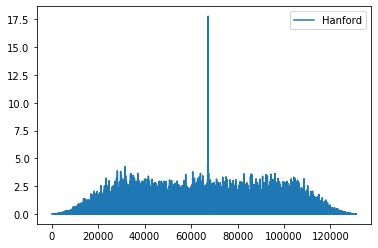

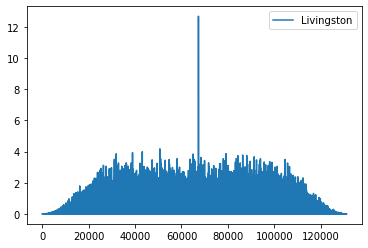

Hanford SNR =  6.720798113725238 and Livingston SNR = 6.055975871945419 and Combined SNR = 9.046765778278877


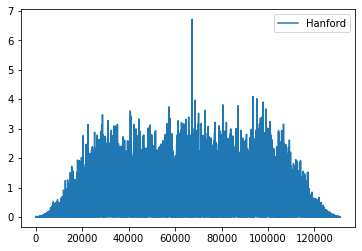

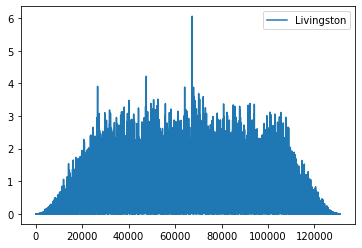

Hanford SNR =  8.887859538757487 and Livingston SNR = 5.245560301493724 and Combined SNR = 10.32036579086659


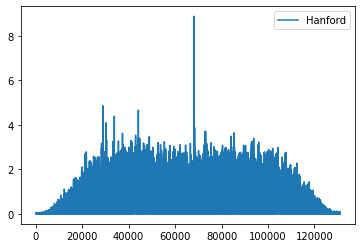

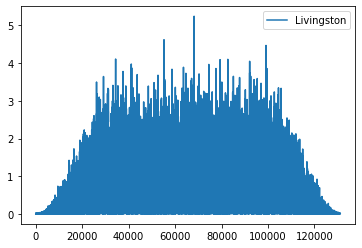

Hanford SNR =  8.35666887454496 and Livingston SNR = 7.98887621858497 and Combined SNR = 11.560971322283478


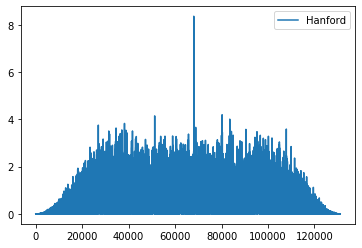

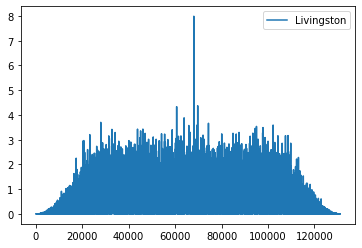

In [71]:
list_SNR = np.zeros((len(list_events),2))
for i in range(len(list_events)):
    HSNR, LSNR = SNR(data[i])
    HSNRmax = np.max(HSNR)
    LSNRmax = np.max(LSNR)
    list_SNR[i,0] = HSNRmax
    list_SNR[i,1] = LSNRmax
    comb = np.sqrt(HSNRmax**2 + LSNRmax**2)
    print('Hanford SNR = ', HSNRmax, 'and Livingston SNR =', LSNRmax, 'and Combined SNR =', comb)

    plt.plot(HSNR, label = 'Hanford')
    plt.legend()
    plt.show()
    plt.plot(LSNR, label = 'Livingston')
    plt.legend()
    plt.show()

In [39]:
print(list_SNR)
print(est_SNR)
print(np.max(list_SNR - est_SNR))

[[17.79292648 12.69092114]
 [ 6.72079811  6.05597587]
 [ 8.88785954  5.2455603 ]
 [ 8.35666887  7.98887622]]
[[17.60102785 12.19703329]
 [ 6.53208384  5.955524  ]
 [ 8.76587213  4.94028427]
 [ 8.38820055  7.8514591 ]]
0.49388784659017126


Comparing our analytic and estimates of SNR, we see that the largest difference is 0.5, which is less than 5% error. We also notice that for the combined SNR, the analytics are always larger so our estimate are underestimating. 

## e.)

In [96]:
def freq(freqs, mf):
    cumsum = np.cumsum(np.abs(mf))
    return freqs[(cumsum < max(cumsum)/2)][-1]
    
sig_freqs = []
for i in range(len(list_events)):    
    _,Htemp,_,Ltemp, Hfreq, Lfreq = white(data[i])
    Hfreq = np.fft.rfftfreq(len(data[i]['H_template']), data[i]['H_dt'])
    Lfreq = np.fft.rfftfreq(len(data[i]['L_template']), data[i]['L_dt'])
    Htemp = np.fft.rfft(Htemp)
    Ltemp = np.fft.rfft(Ltemp)
    sig_freq = freq(Hfreq, Htemp)
    sig_freqs.append(sig_freq)
    print("Hanford signal frequency =", sig_freq)

    sig_freq = freq(Lfreq, Ltemp)
    sig_freqs.append(sig_freq)
    print("Livingston signal frequency =", sig_freq)
    
print("Average signal frequency =", np.average(sig_freqs))

Hanford signal frequency = 136.3125
Livingston signal frequency = 138.78125
Hanford signal frequency = 129.46875
Livingston signal frequency = 135.8125
Hanford signal frequency = 149.625
Livingston signal frequency = 176.1875
Hanford signal frequency = 141.1875
Livingston signal frequency = 121.125
Average signal frequency = 141.0625


## f.)

In [123]:
time_diff = []
for i in range(len(list_events)):
    Ht, Hmf, Lt, Lmf = match_filter(data[i])
    Htime = Ht[np.argmax(Hmf)]
    Ltime = Lt[np.argmax(Lmf)]
    time_diff.append(Htime - Ltime)
    
c = 3*10**8
print('Time uncertainty is', np.mean(np.abs(time_diff)),'s')
print('Positional uncertainty is', np.mean(np.abs(time_diff))*c/1000, 'km')

Time uncertainty is 0.00238037109375 s
Positional uncertainty is 714.111328125 km
